## TODO
- Add portfolio amounts

In [183]:
import requests
from lxml import html
from datetime import datetime
import csv
import datetime
import re
import os
import pandas as pd 
import matplotlib as plt
%matplotlib inline

In [184]:
settings = {
    'homeDir': os.getcwd() + '\\',
    'fileName': 'tickers.csv' 
}

class Company:
    def __init__(self, ticker):
        self.ticker = ticker

    def scrape(self):
        ticker = self.ticker
        page = requests.get("https://www.tickertech.net/bnkinvest/cgi/?n=2&ticker=" + ticker + "&js=on&head=1&a=historical&w=dividends2&noform=1&footer=off")

        tree = html.fromstring(page.content)
        divElements = tree.xpath('//*[@id="histtable"]')

        for e in divElements:
            s = str(e.text_content())

        s = s.splitlines()

        list = []
        for e in s:
            item = re.findall('\[[^\]]*\]|\([^\)]*\)|\"[^\"]*\"|\S+',e)

            try:
                q = re.findall(r"'(.*?)'", item[3], re.DOTALL)
                q = str(q).replace("\\n","").replace("\\","").replace("['","").replace("']","")

                if (len(q) > 2) and (hasNumbers(q)):
                    list.append(q)
            except:
                pass

        divList = []
        for i in range(len(list)-1):
            divList.append([list[i], list[i+1]])

        for i in divList:
                if ("." not in i[1]):
                	divList.remove(i)

        # Write Output to <ticker>.csv
        with open(settings['homeDir'] + 'output/' + ticker + '.csv', 'w', newline="\n", encoding="utf=8") as file:
                file.write("date,ticker,amount\n")
                for e in divList:
                        file.write(e[0] + ',' + ticker + ',' + e[1] + '\n')

    def get_dividends(self):
        df = pd.read_csv('output/' + self.ticker + '.csv')
        return df

def hasNumbers(inputString):
        return any(char.isdigit() for char in inputString)

class tickerList:

    def get(self):

        #Read tickers.csv and return as list 
        with open(settings['homeDir'] + settings['fileName'], 'r') as file:
            reader = csv.reader(file)
            data = list(reader)

        return data

    def add(self, ticker):
        
        # Append to file
        fd = open(settings['homeDir'] + settings['fileName'],'a')
        fd.write("\n" + ticker)
        fd.close()

        tickerList = self.get()
        return tickerList

    def remove(self, ticker):
        return 'leeg'

In [185]:
# Create new df with all dividend payments 
companies = tickerList().get()
df = pd.DataFrame()

for company in companies:
    company = company[0] 
    companyData = Company(str(company))
    companyData.get_dividends()
    data = companyData.get_dividends()
    df = df.append(data)

In [186]:
portfolio = pd.read_csv("portfolio.csv")
df = df.reset_index(drop=False)
df = df.set_index('ticker')
portfolio = portfolio.set_index('ticker')
df['portfolio'] = portfolio['amount'] 
df['total_amount'] = df['amount']*df['portfolio']

In [187]:
df = df.reset_index(drop=False)
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
del df['index']

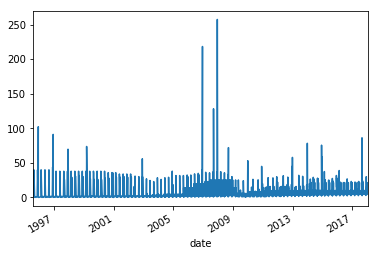

In [189]:
df['total_amount'].plot()